In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodbmysql.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbmysqltest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.005656,0.000089,0.0,17931.377778,0.007200,16138.355556,53534.133333,1.0,1.0,2.842053,12.0,5.188889,5.045532e+10,9.907735
1,0.003688,0.000089,0.0,13471.288889,0.007200,16707.733333,50657.800000,1.0,2.0,2.668923,12.0,5.075000,5.045532e+10,9.943913
2,0.316843,0.000000,0.0,21026.133333,0.012803,20102.600000,56847.955556,1.0,3.0,2.667665,12.0,5.075000,5.045532e+10,9.943913
3,0.416394,0.000000,0.0,12196.977778,0.012803,19553.177778,53704.466667,1.0,5.0,2.590923,12.0,5.405556,5.045532e+10,9.902425
4,0.405535,0.000089,0.0,13198.222222,0.013208,19600.688889,56622.866667,1.0,5.0,2.654380,12.0,5.405556,5.045532e+10,9.902425


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,0.417187,499.897945,2.842053,1.0
1,0.408030,501.723328,2.668923,2.0
2,0.408030,501.723328,2.667665,3.0
3,0.434607,499.630067,2.590923,5.0
4,0.434607,499.630067,2.654380,5.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2692,4.044972,734.878925,7.877088,153.0
2693,3.991413,705.801830,6.017522,152.0
2699,3.255268,672.161587,7.870471,111.0
2705,2.733823,655.914394,7.899868,113.0
2712,2.662092,664.194048,9.538560,108.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(1491, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

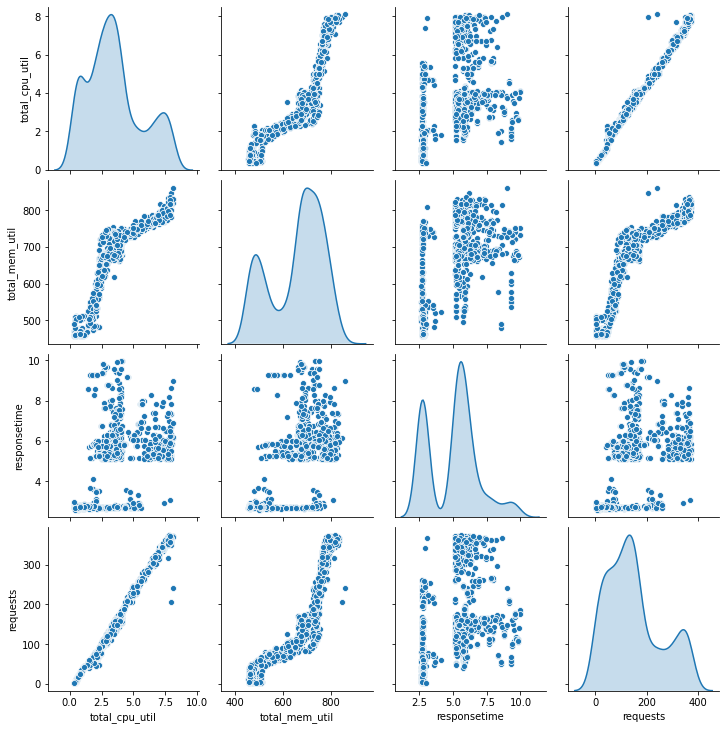

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,1193.0,3.517529,2.125388,0.355993,2.038810,3.220467,4.697808,8.113253
total_mem_util,1193.0,658.610064,109.545387,456.428544,556.968348,684.961382,742.265856,861.294797
responsetime,1193.0,5.056253,1.841645,2.590923,2.783681,5.372033,5.974626,9.950546
requests,1193.0,150.434199,105.238540,1.000000,68.000000,133.000000,211.000000,375.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
9,0.468107,502.512217,2.654881,7.0
1531,3.844035,672.569635,6.086172,164.0
611,3.539610,729.575424,6.011854,160.0
331,7.524323,781.962848,5.581043,354.0
664,4.869962,749.717299,5.142396,209.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
normalizer = preprocessing.Normalization()

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[  3.518 658.61    5.056]


## Linear Regression

In [18]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [19]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [20]:
model.predict(test_features)

array([[-3.027],
       [-3.042],
       [-3.087],
       [-3.091],
       [-3.051],
       [-3.037],
       [-3.029],
       [-3.041],
       [-2.96 ],
       [-2.981],
       [-3.036],
       [-3.03 ],
       [-3.001],
       [-3.021],
       [-2.966],
       [-1.482],
       [-1.435],
       [-1.435],
       [-1.506],
       [-1.506],
       [-1.409],
       [-1.409],
       [-1.41 ],
       [-1.41 ],
       [-1.388],
       [-1.388],
       [-1.413],
       [-1.413],
       [-1.311],
       [-1.317],
       [-1.338],
       [-1.338],
       [-1.26 ],
       [-1.26 ],
       [-1.35 ],
       [-1.35 ],
       [-1.337],
       [-1.337],
       [-1.287],
       [-1.287],
       [-1.214],
       [-1.214],
       [-1.191],
       [-1.191],
       [-0.659],
       [-0.659],
       [-0.566],
       [-0.566],
       [-0.53 ],
       [-2.022],
       [-2.148],
       [-2.171],
       [-1.882],
       [-1.786],
       [-1.624],
       [-1.656],
       [-1.393],
       [-1.41 ],
       [-1.427

In [21]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [22]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 5.88 s, sys: 823 ms, total: 6.71 s
Wall time: 5.85 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,6.587667,5.939492,95
96,6.578541,5.933252,96
97,6.587464,5.957983,97
98,6.576860,5.963979,98
99,6.604640,5.963621,99


In [38]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

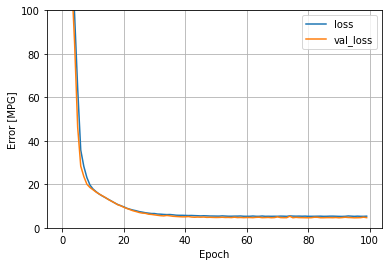

In [39]:
plot_loss(history)

In [40]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [41]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [42]:
dnn_model = build_and_compile_model(input_normalizer)

In [43]:
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [44]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 8.9 s, sys: 1.16 s, total: 10.1 s
Wall time: 6.47 s


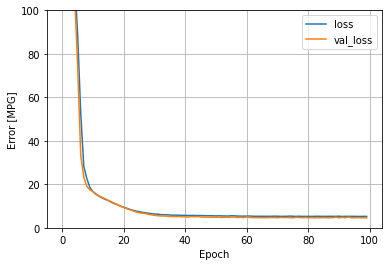

In [45]:
plot_loss(history)

In [32]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [33]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,6.445238
dnn_model,5.305232


## Make Predictions

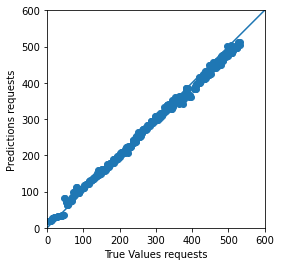

In [46]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [35]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.9929045153593568


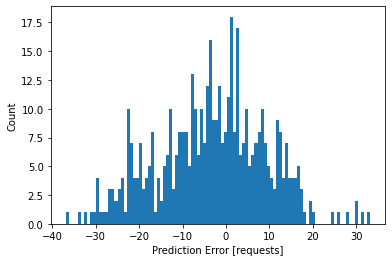

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')